<a href="https://colab.research.google.com/github/Amirbapiri/book_chewer/blob/master/GANs_anime_char.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets --upgrade --quiet

In [3]:
import opendatasets as od

dataset_url = "https://www.kaggle.com/splcher/animefacedataset"

od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: themir
Your Kaggle Key: ··········


100%|██████████| 395M/395M [00:04<00:00, 88.9MB/s]


In [4]:
import os

In [5]:
DATA_DIR = "./animefacedataset/"
print(os.listdir(DATA_DIR))

['images']


In [6]:
os.listdir(DATA_DIR+"/images")[:10]

['14012_2006.jpg',
 '7462_2004.jpg',
 '55589_2016.jpg',
 '27057_2009.jpg',
 '1453_2001.jpg',
 '17060_2007.jpg',
 '23482_2008.jpg',
 '46303_2014.jpg',
 '41642_2013.jpg',
 '23840_2008.jpg']

In [7]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [8]:
image_size = 64
batch_size = 128
stats = (.5, .5, .5), (.5, .5, .5)

In [9]:
train_ds = ImageFolder(
    DATA_DIR,
    transform=T.Compose([
        T.Resize(image_size),
        T.CenterCrop(image_size),
        T.ToTensor(),
        T.Normalize(*stats)
    ])
)

train_loader = DataLoader(
    train_ds,
    batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
)

# Some helper functions

In [10]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import matplotlib_inline

In [11]:
matplotlib_inline.backend_inline.display("svg")

'svg'

In [12]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images: torch.Tensor, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))

    ax.set_xticks([]);
    ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))


def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

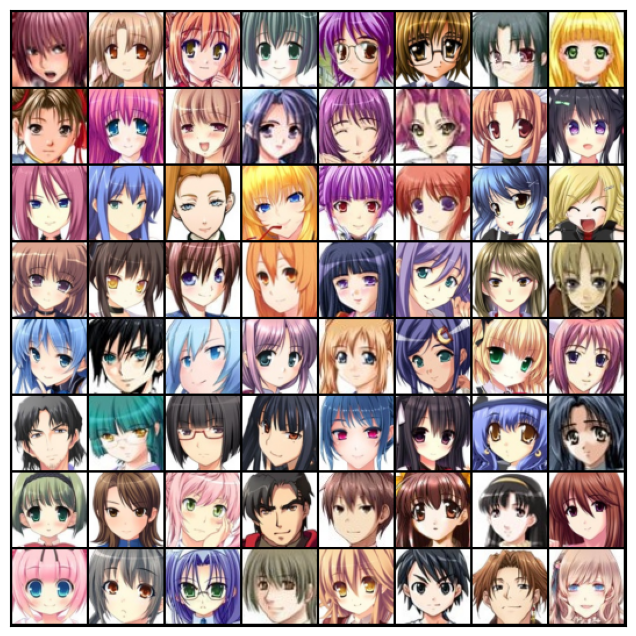

In [13]:
show_batch(train_loader)

In [14]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")

In [15]:
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [16]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)

    def __len__(self):
        return len(self.dl)

In [17]:
device = get_default_device()

print(device)

cpu


In [18]:
train_loader = DeviceDataLoader(train_loader, device)

In [19]:
import torch.nn as nn

In [20]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: (((64 - 2(1)) - 1) + 4) / 2 = 32
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: (((32 - 2(1)) - 1) + 4) / 2 = 16
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: (((16 - 2(1)) - 1) + 4) / 2 = 8
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: (((8 - 2(1)) - 1) + 4) / 2 = 4
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: (((4 - 2(0)) - 1) + 4) / 1 = 7
    # out: 1 x 7 x 7

    nn.Flatten(),
    nn.Sigmoid(),
)

In [21]:
discriminator = to_device(discriminator, device)

In [22]:
latent_size = 128

generator = nn.Sequential(
    nn.ConvTranspose2d(
        latent_size,
        512,
        kernel_size=4,
        stride=1,
        padding=0,
        bias=False,
    ),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(
        512,
        256,
        kernel_size=4,
        stride=2,
        padding=1,
        bias=False,
    ),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(
        256,
        128,
        kernel_size=4,
        stride=2,
        padding=1,
        bias=False,
    ),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(
        128,
        64,
        kernel_size=4,
        stride=2,
        padding=1,
        bias=False,
    ),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(
        64,
        3,
        kernel_size=4,
        stride=2,
        padding=1,
        bias=False,
    ),
    nn.Tanh()
)

torch.Size([128, 128, 1, 1])
torch.Size([128, 3, 64, 64])


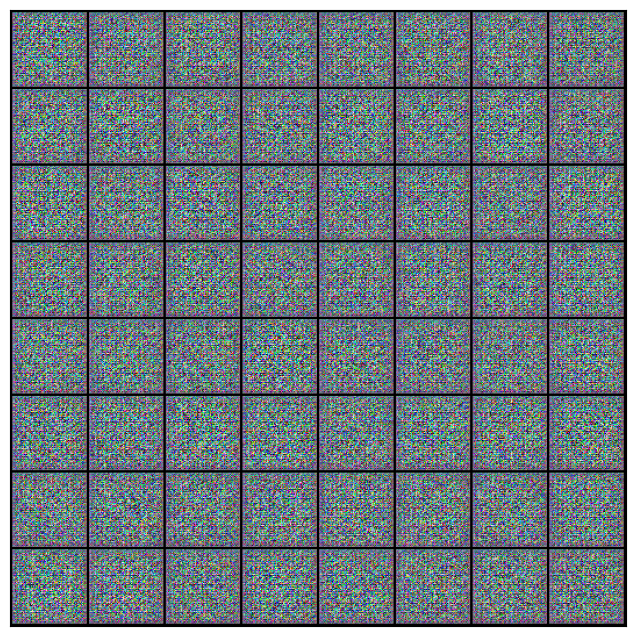

In [23]:
xb = torch.randn(batch_size, latent_size, 1, 1)
print(xb.shape)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [24]:
generator = to_device(generator, device)

## Training models

### Train the discriminator

In [27]:
from torch.nn import functional as F

In [28]:
def train_discriminator(real_images, opt_d):
    opt_d.zero_grad()

    # pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()

    return loss.item(), real_score, fake_score


### Train the generator

In [29]:
def train_generator(opt_g):
    opt_g.zero_grad()

    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # trying to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(input=preds, target=targets)

    loss.backward()
    opt_g.step()

    return loss.item()

In [30]:
from torchvision.utils import save_image

In [31]:
sample_dir = "generated"
os.makedirs(sample_dir, exist_ok=True)

In [32]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = f"generated-images-{index}.png"
    save_image(
        denorm(fake_images), os.path.join(sample_dir, fake_fname),
    nrow=8)
    print(f"Saving: {fake_fname}")

    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [33]:
latent_tensors = torch.randn(64, latent_size, 1, 1, device=device)

Saving: generated-images-0.png


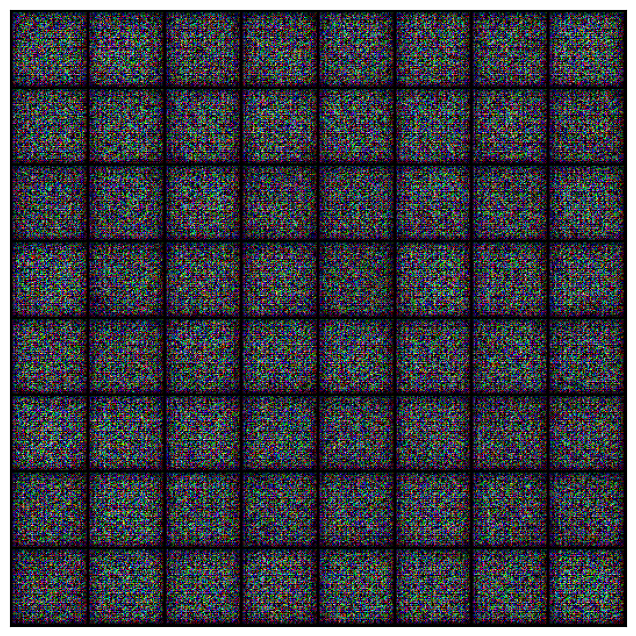

In [34]:
save_samples(0, latent_tensors)

In [35]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [36]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    losses_g = list()
    losses_d = list()
    real_scores = list()
    fake_scores = list()

    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(.5, .999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(.5, .999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_loader):
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            loss_g = train_generator(opt_g)

        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        print(f"Epoch [{epoch}/{epochs}], loss_g: {loss_g:2f}, loss_d: {loss_d:2f}, real_score: {real_score:4f}, fake_score: {fake_score:4f}")

        save_samples(epoch+start_idx, latent_tensors, show=False)

    return losses_g, losses_d, real_scores, fake_scores



In [37]:
lr=0.0002
epochs = 10

In [38]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

KeyboardInterrupt: ignored